In [134]:
import pandas as pd
import numpy as np
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from src.tags_helpers.tag_grouper import TagGrouper
from src.tags_helpers.graph_plotting import describe_graph, plot_degree_distribution
from src.event_helper.plot_events import read_and_plot_events

# import interactive plots
import plotly.graph_objects as go


# Automatic reloading of modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import the data around COP21

In [135]:
file_name = 'data/climate_videos_v3.jsonl'
climate_videos_df = pd.read_json(file_name, lines=True)
climate_videos_df['upload_date'] = pd.to_datetime(climate_videos_df['upload_date'])
climate_videos_df.set_index('upload_date', inplace=True)
climate_videos_df.sort_index(inplace=True)
date_limit = '2019-07-01'

climate_videos_df = climate_videos_df.loc[:date_limit].copy()  #avoid crawl date
cop21_df = climate_videos_df.loc['2015-12-01':'2015-12-31'].copy()

climate_videos_df.reset_index(inplace=True)
climate_videos_df.set_index('display_id', inplace=True)
cop21_df.reset_index(inplace=True)
cop21_df.set_index('display_id', inplace=True)

climate_videos_df.head()

,upload_date,categories,channel_id,crawl_date,description,dislike_count,duration,like_count,tags,title,view_count,classification_categories
display_id,,,,,,,,,,,,
rXVcnciIduc,2006-05-23,Howto & Style,UC5MOW8BO3dH38Fo3Rau17KQ,2019-11-02 01:19:20.939142,Water vapour is the primary greenhouse gas.,0.0,61,8.0,"science,climatechange,weather",Professor Tim Palmer on climate change,1644,{'/Science/Ecology & Environment/Climate Chang...
UhVk4R_T7O8,2006-06-07,News & Politics,UCy1UzIJf_Dog0vzLJUPLXHA,2019-11-03 12:38:39.986280,"The DuPont plant in DeLisle, Mississippi has b...",6.0,1713,48.0,"dioxin,duplicity,dupont,sierra,club,chronicles...","Dioxin, Duplicity & Dupont - Sierra Club Chron...",7399,{'/People & Society/Social Issues & Advocacy/G...
RUjM59H3fYk,2006-07-19,News & Politics,UC61qQBrHiNKprDXW5ZnLPyQ,2019-11-03 07:02:08.742306,HotAir.com's Michelle Malkin jumps! to fight g...,104.0,199,192.0,"global,warming,environment,world,jump,day,mich...",VENT Jump!,61816,{'/Science/Ecology & Environment/Climate Chang...
MvTaLdk3-dE,2006-09-07,Howto & Style,UC5MOW8BO3dH38Fo3Rau17KQ,2019-11-02 01:19:20.354547,Hear from the people behind the BBC's global c...,1.0,146,6.0,"science,climate,global,warming,distributed,tem...",What might the climate be in 2053?,1092,{'/Science/Ecology & Environment/Climate Chang...
6otdzD8ncnw,2006-09-22,Music,UCNia_X3a7HLxBSN-z57UGQw,2019-11-04 22:29:01.019235,Musician G. Love and NRDC's Dan Lashof drop rh...,2.0,184,1.0,"nrdc,environment,music,g.love,globalwarming,en...",NRDC at Bonnaroo -- Solve Global Warming!,1033,{'/People & Society/Social Issues & Advocacy/G...


# Map tags to a smaller subset

In [136]:
def preprocess_tags(data: pd.DataFrame):
    tag_grouper = TagGrouper()   
    tqdm.pandas()
    data = data.apply(lambda tags: tags.split(','))
    data = data.progress_apply(lambda tags: [tag for tag in tags if tag != ''])
    data = data[data.progress_apply(lambda tags: len(tags) > 0)]
    data = data.progress_apply(lambda tags: [tag_grouper.get(tag) for tag in tags])
    tag_grouper.save()
    return data

data = preprocess_tags(climate_videos_df['tags'])

100%|██████████| 59156/59156 [00:00<00:00, 71886.24it/s]


# Take a look at the tag counts

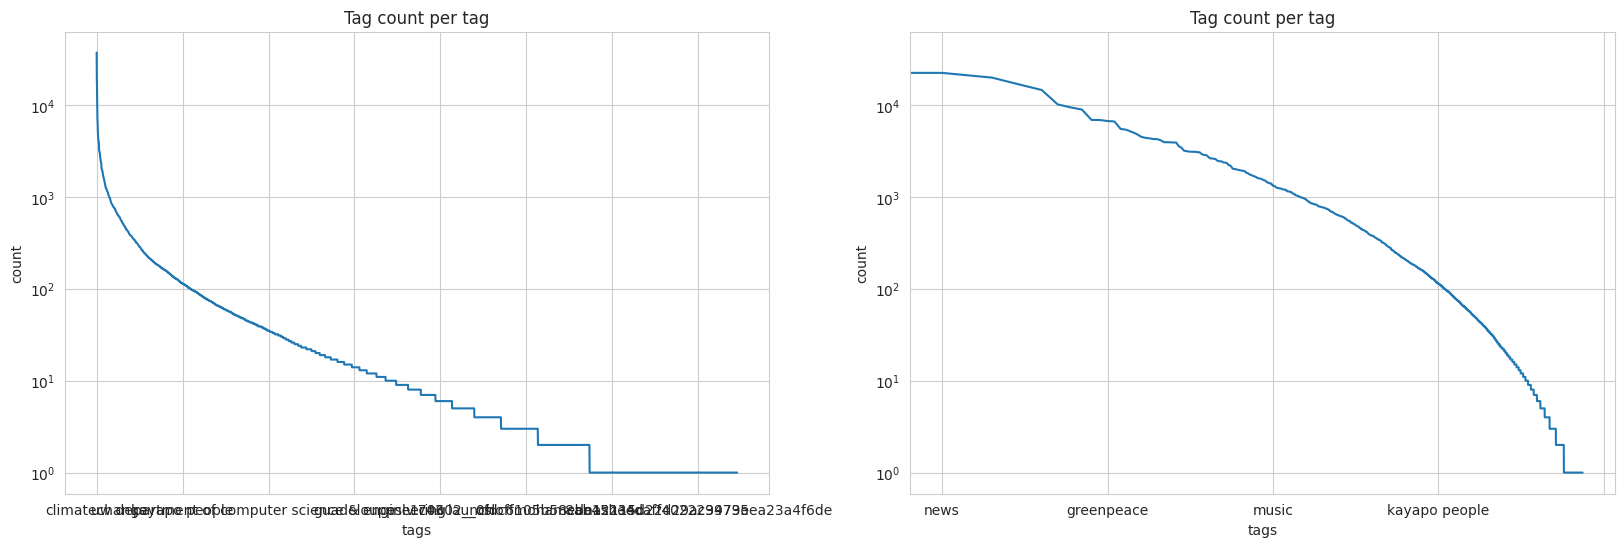

climatechange                                         37356
news                                                  22457
pollution                                             19953
environment                                           16603
warming                                               14629
                                                      ...  
электромобиль                                             1
окружающая среда                                          1
scooptag:100000006101866                                  1
kenya rated position 119 in implementation of sdgs        1
722d0d1d6e53471cc70172f29c1e5d34                          1
Length: 7454, dtype: int64

In [149]:
tags_count = pd.Series(dict(Counter(tag for tags in data for tag in tags)))
tags_count.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
tags_count.plot(xlabel='tags', ylabel='count', ax=ax[0], logy=True, logx=False, grid=True, title='Tag count per tag')
tags_count.plot(xlabel='tags', ylabel='count', ax=ax[1], logy=True, logx=True, grid=True, title='Tag count per tag')
plt.show()
tags_count

# Only keep the top 90th percentile of tags 

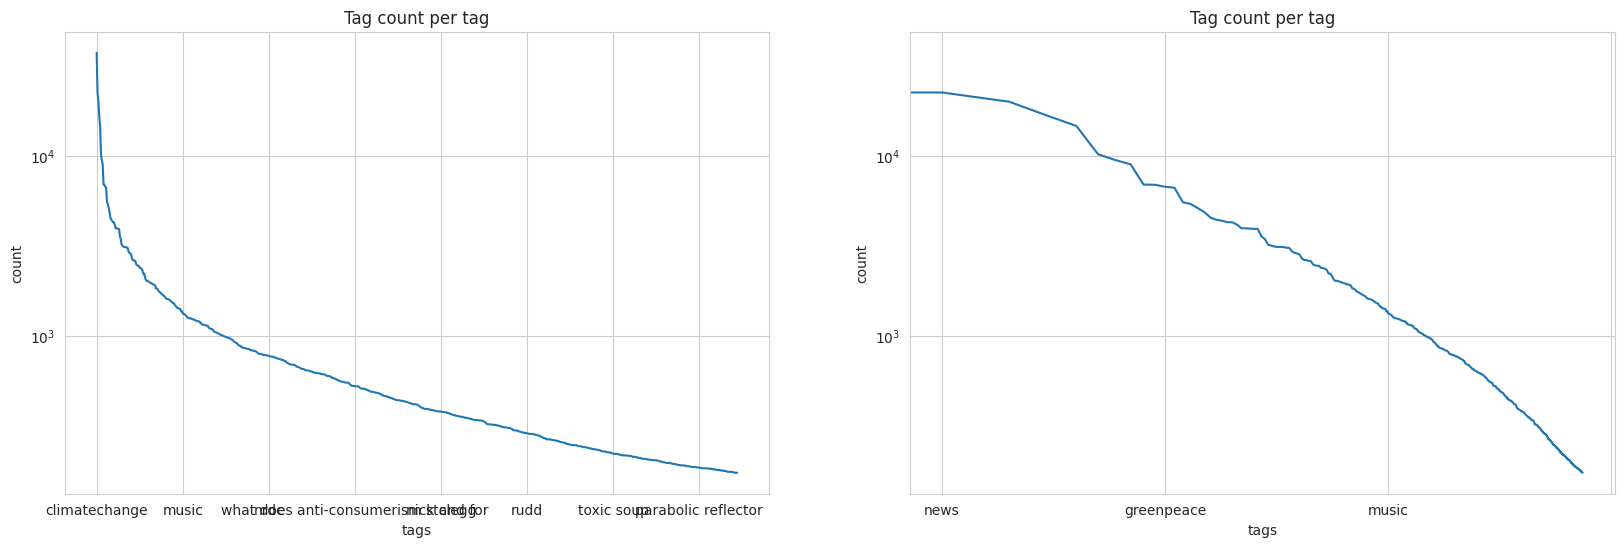

climatechange         37356
news                  22457
pollution             19953
environment           16603
warming               14629
                      ...  
gregory miller          174
reprobate mind          173
lawrence livermore      173
u.s. senate             173
penguin books           173
Length: 745, dtype: int64

In [150]:
threshold = tags_count.quantile(0.9)
common_tags_count = tags_count[tags_count > threshold]
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
common_tags_count.plot(xlabel='tags', ylabel='count', ax=ax[0], logy=True, logx=False, grid=True, title='Tag count per tag')
common_tags_count.plot(xlabel='tags', ylabel='count', ax=ax[1], logy=True, logx=True, grid=True, title='Tag count per tag')
plt.show()
common_tags_count

In [139]:
year_data = pd.DataFrame(data)
year_data = year_data.merge(pd.to_datetime(climate_videos_df['upload_date']), left_index=True, right_index=True)

top_tags = list(common_tags_count.index)[:4]
for tag in top_tags:
    year_data[tag] = data.progress_apply(lambda x: int(tag in x))

tags_count_per_date = year_data.groupby('upload_date')[top_tags].sum()

# Load the event data
climate_event = pd.read_csv('data/climate_events_v2.csv', index_col=0, parse_dates=True)
climate_event = climate_event.loc[:date_limit]

# Interactive plot
fig = go.Figure()

# Add events on the interactive plot
for event in climate_event.itertuples():
    fig.add_shape(
        # Line Vertical
        type='line',
        x0=event.Index,
        x1=event.Index,
        y0=0,
        y1=120,
        line=dict(color='black', width=0.5, dash='dash'),
        name=f'{"event"} Date',
    )
    
for tag in top_tags:
    fig.add_trace(go.Scatter(x=tags_count_per_date.index, y=tags_count_per_date[tag], name=tag))
fig.update_layout(
    title='Tag count per day with climate events', xaxis_title='Date', 
    yaxis_title='Number of tags', legend_title='Tags',
    width=1100, height=600,
)
    
fig.show()

100%|██████████| 59156/59156 [00:00<00:00, 647860.46it/s]


# Focus on cop21 event

In [141]:
# Keep data of december 2015
cop21_data = cop21_df['tags']
cop21_data = preprocess_tags(cop21_data)

# Only keep the top 90th percentile of tags
cop21_tags_count = pd.Series(dict(Counter(tag for tags in cop21_data for tag in tags)))
cop21_tags_count.sort_values(inplace=True, ascending=False)
threshold = cop21_tags_count.quantile(0.9)
cop21_common_tags_count = cop21_tags_count[cop21_tags_count > threshold]
# Filter the tags in the dataframe
videos = list(cop21_data.index)
common_tags = set(cop21_common_tags_count.index)
cop21_data = cop21_data.apply(lambda x: [tag for tag in x if tag in common_tags])
cop21_data = cop21_data[cop21_data.progress_apply(lambda tags: len(tags) > 0)]

100%|██████████| 1219/1219 [00:00<00:00, 981354.43it/s]


# Create the bipartite graph between videos and tags

In [142]:
G = nx.Graph()
G.add_nodes_from(common_tags, bipartite=0)
G.add_nodes_from(videos, bipartite=1)

for video, tags in tqdm(cop21_data.items(), total=len(cop21_data)):
    for tag in tags:
        G.add_edge(video, tag)
print(G)

100%|██████████| 1190/1190 [00:00<00:00, 80118.49it/s]

Graph with 1376 nodes and 9810 edges


# Plot a subgraph to visualize the data

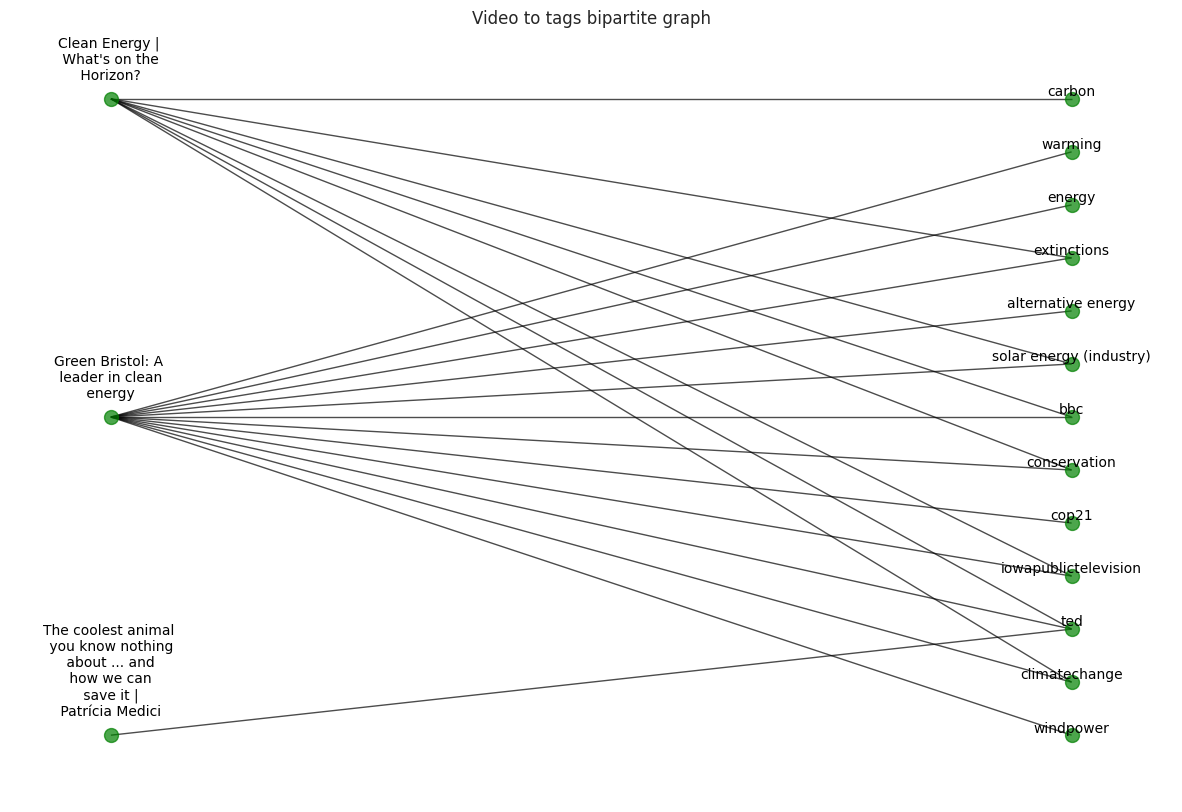

In [151]:
sub_videos = videos[8:11].copy()
sub_videos_names = list(cop21_df.loc[sub_videos, 'title'].values)

def add_to_line(name: str, consec_words: int = 3) -> str:
    name_split = name.split(' ')
    new_split = []
    n_words = 3
    for i in range(0, len(name_split), n_words):
        new_split.extend(name_split[i: i + n_words])
        new_split.append('\n')
    return ' '.join(new_split)

sub_videos_names = [add_to_line(name) for name in sub_videos_names]

sub_tags = []
for node in sub_videos:
    sub_tags.extend(list(G.neighbors(node))[:-3])
    
sub_nodes = sub_videos + sub_tags
sub_labels = sub_videos_names + sub_tags
sub_labels = {n:l for n,l in zip(sub_nodes, sub_labels)}
subgraph = G.subgraph(sub_nodes)

fig, ax = plt.subplots(figsize=(15, 10))
pos = nx.bipartite_layout(subgraph, nodes=sub_videos, scale=1, aspect_ratio=4/3)  # Set the layout for bipartite graphs
nx.draw(subgraph, with_labels=False, pos=pos, node_size=100, font_size=10, font_weight='bold', node_color='green', alpha=0.7)
nx.draw_networkx_labels(subgraph, pos, labels=sub_labels, font_size=10, verticalalignment='bottom')
plt.title('Video to tags bipartite graph')
plt.show()

# Project the graph onto the tags

In [144]:
print("Start")
tag_graph = nx.bipartite.weighted_projected_graph(G, common_tags, ratio=True)
print(tag_graph)

Start
Graph with 157 nodes and 7879 edges


# Describe the graph

100%|██████████| 157/157 [00:00<00:00, 772894.05it/s]


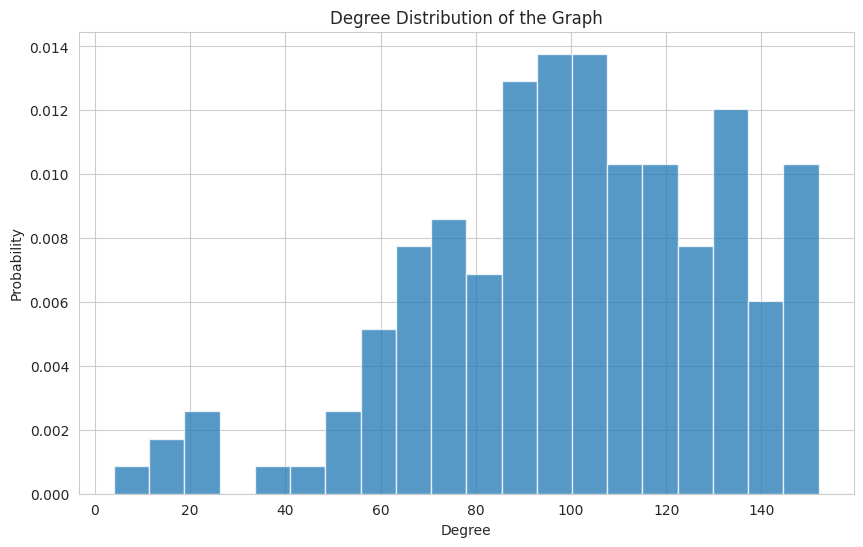

Graph with 157 nodes and 7879 edges
Avg. Shortest Path Length: 1.3569
Diameter: 3.0000
Sparsity: 0.6434
Global clustering coefficient aka Transitivity: 0.7617


In [152]:
# Plot the degree distribution
degree_sequence = [d for n, d in tqdm(tag_graph.degree())]
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(degree_sequence, bins=20, density=True, alpha=0.75)
plt.title("Degree Distribution of the Graph")
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.show()

# Describe the graph
describe_graph(tag_graph)

From the above graph description, we can see that the graph is highly connected, with a high clustering coefficient and a low average path length. This means that the graph is a small world graph. 

In [146]:
# Create a subgraph with the top 25 edges neighbors of cop21
cop21_tag = TagGrouper().get('cop21')
edges = tag_graph.edges.data('weight')
cop21_edges = [e for e in edges if cop21_tag in e]

# keep the top 25 edges
cop21_edges.sort(key=lambda x: x[2], reverse=True)
cop21_edges = cop21_edges[:25]

filtered_graph = nx.Graph()  
filtered_graph.add_weighted_edges_from(cop21_edges)
cop21_nodes = list(filtered_graph.neighbors(cop21_tag)) + [cop21_tag]
cop21_graph = filtered_graph.subgraph(cop21_nodes)

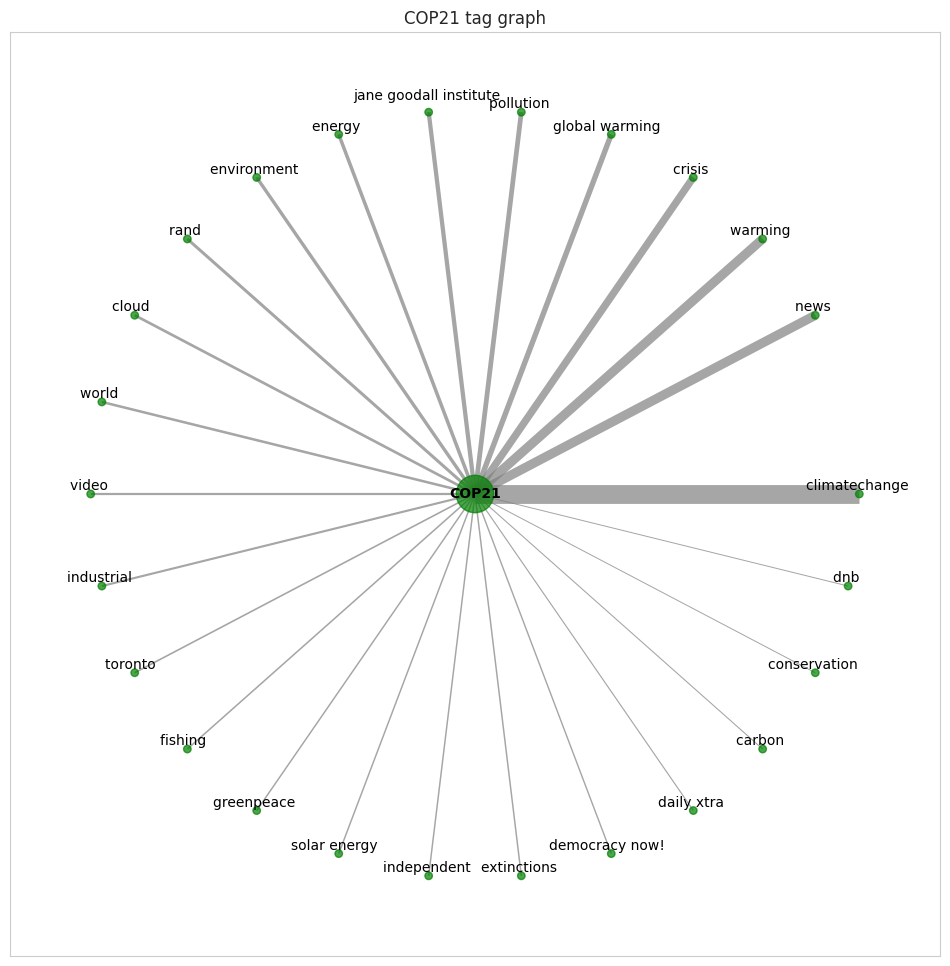

In [154]:
def plot_tag_graph(graph: nx.Graph):
    plt.figure(figsize=(12, 12))
    # pos = nx.spring_layout(graph, k=1.1, iterations=20, center=['cop21'])  # Set the layout for bipartite graphs
    # pos = nx.circular_layout(graph)
    
    # Create the positions of the nodes with cop21 in the center and the others aaround it
    pos = {n: (np.cos(i / len(graph) * 2 * np.pi), np.sin(i / len(graph) * 2 * np.pi)) for i, n in enumerate(graph.nodes())}
    pos['cop21'] = (0, 0)
    
    edges = graph.edges.data('weight')
    weights = np.array([w for _, _, w in edges])
    weights = (weights - weights.min() + 0.01) / (weights.max() - weights.min() + 0.1) * 20 
    
    degrees = np.array([d for _, d in graph.degree()]) 
    degrees = degrees / (degrees.max() - degrees.min() + 0.1) * 700   # Min max normalize the degrees
    
   
    def remove_parenthesis(name: str) -> str:
        if '(' in name:
            return name[:name.index('(')]
        return name
    
    labels = {n: add_to_line(remove_parenthesis(n), consec_words=2) for n in graph.nodes()}
    labels.pop('cop21')
    
    nx.draw_networkx_nodes(graph, pos, node_size=degrees, node_color='green', alpha=0.7)
    nx.draw_networkx_edges(graph, pos, width=weights, edge_color='grey', alpha=0.7)
    nx.draw_networkx_labels(graph, pos, font_size=10, labels=labels)
    nx.draw_networkx_labels(graph, pos, font_size=10, labels={'cop21': 'COP21'}, font_weight='bold')
    plt.title('COP21 tag graph')
    plt.grid(False)
    plt.show()
    
plot_tag_graph(cop21_graph)
